# Simulating Termination Process

In [13]:
# imports

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from pacssim.ArrivalProcess import SimProcess, ExpSimProcess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Simulated Average Inter-Event Time: 0.199937
Simulated Average Event Rate: 5.001564


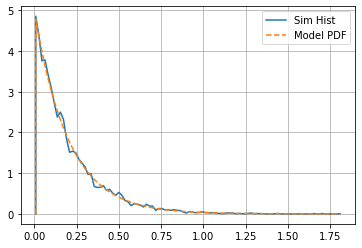

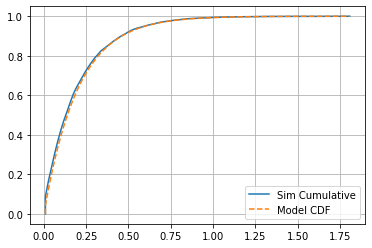

In [7]:
# plotting sample exponential process
exp_arr = ExpSimProcess(rate=5)
exp_arr.visualize(num_traces=10000, num_bins=100)

Simulated Average Inter-Event Time: 1032.493489
Simulated Average Event Rate: 0.000969


(0.0, 0.001)

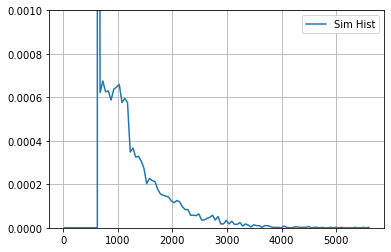

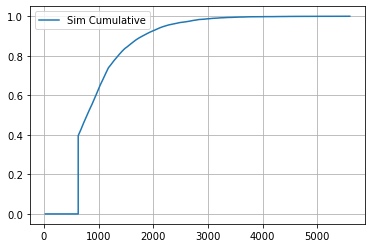

In [14]:
class ExTermProcess(SimProcess):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.has_pdf = False
        self.has_cdf = False

        required_fields = ['arr_rate', 'exp_time', 'max_warm_time']
        for key in required_fields:
            if kwargs.get(key) is None:
                Exception(f"You need to provied a {key}!")

        self.arr_rate = kwargs.get('arr_rate')
        self.exp_time = kwargs.get('exp_time')
        self.max_warm_time = kwargs.get('max_warm_time')


    def generate_trace(self):
        t_t, _ = self.generate_termination_trace()
        return t_t

    def generate_termination_trace(self):
        t_exp = self.exp_time
        max_sim_time = self.max_warm_time
        t = 0
        t_t = 0
        req_count = 0
        while t < max_sim_time:
            dt = np.random.exponential(1/self.arr_rate)
            # if termination will happen
            if dt > t_exp:
                t_t = t + t_exp
                break
            # Add one to the number of requests
            req_count += 1
            # update time since evaluation
            t += dt
            # update termination time (in case we surpass max_sim_time)
            t_t = t
        return t_t, req_count

term_process = ExTermProcess(arr_rate=1/(10*60), exp_time=10*60, max_warm_time=24*60*60)
term_process.visualize(num_traces=10000, num_bins=100)
plt.figure(1)
plt.ylim((0, 0.001))